In [1]:
%%HTML
<style>.container { width:100% !important; }</style>

# Classification

Use apropriate metric and \*Classifier classes instead of \*Regressor

Good guide to classical problem 

https://www.kaggle.com/harunshimanto/titanic-solution-for-beginner-s-guide

http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [2]:
import matplotlib.pyplot as plt

from sklearn import datasets, metrics
# The digits dataset
digits = datasets.load_digits()
print(dir(digits))
print(' digits.data.shape: %s \n digits.images.shape: %s \n digits.target.shape: %s \n' % (digits.data.shape, digits.images.shape, digits.target.shape))

['DESCR', 'data', 'images', 'target', 'target_names']
 digits.data.shape: (1797, 64) 
 digits.images.shape: (1797, 8, 8) 
 digits.target.shape: (1797,) 



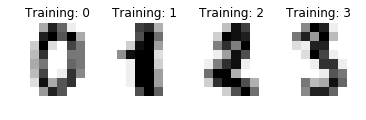

In [3]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [4]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
print(X.shape)
y = digits.target

(1797, 64)


In [5]:
#Split the data
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [6]:
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier()
lgb_model.fit(train_X, train_y)
lgb_preds = lgb_model.predict(val_X)
# https://en.wikipedia.org/wiki/Precision_and_recall
print(metrics.classification_report(val_y, lgb_preds))
print(metrics.confusion_matrix(val_y, lgb_preds))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        37
          1       0.91      0.98      0.94        43
          2       0.98      0.95      0.97        44
          3       0.93      0.96      0.95        45
          4       0.95      0.97      0.96        38
          5       0.96      0.98      0.97        48
          6       1.00      0.96      0.98        52
          7       0.98      0.98      0.98        48
          8       0.98      0.90      0.93        48
          9       0.94      0.96      0.95        47

avg / total       0.96      0.96      0.96       450

[[36  0  0  0  0  1  0  0  0  0]
 [ 0 42  0  0  1  0  0  0  0  0]
 [ 1  0 42  0  0  0  0  0  1  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 47  0  0  0  1]
 [ 0  2  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  1  0  0 47  0  0]
 [ 0  2  0  2  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  0 45]]


/home/artem/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


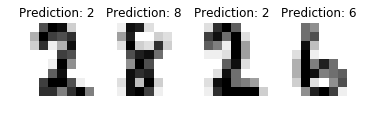

In [7]:
#plot last 4 predictions
images_and_predictions = list(zip(val_X, lgb_preds))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()

# Try own image

## PIL library

Various functions to work with images

https://pillow.readthedocs.io/en/5.1.x/

```
pip install Pillow
```

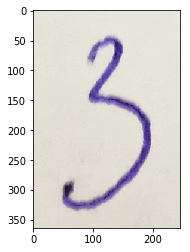

In [8]:
from PIL import Image, ImageChops
tryLoadImage = Image.open('./digits/digit_3.png')
plt.imshow(tryLoadImage)

In [9]:
from sklearn.preprocessing import minmax_scale
import numpy as np

def loadAndFitImage(im):
    # trim borders
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    result = im
    if bbox:
        result = im.crop(bbox)
    # convert to greyscale and resize
    result = result.convert('L')
    result.thumbnail((8, 8))
    # add borders again to fit to 8*8
    if result.width < 8 or result.height < 8:
        bg = Image.new('L', (8, 8), 'white')
        xCoord = (8 - result.width) // 2
        yCoord = (8 - result.height) // 2
        bg.paste(result, (xCoord, yCoord))
        result = bg
    return result

def preprocessImage(fileName):
    imSample = loadAndFitImage(Image.open(fileName).convert('1'))
    imAsVector = 255 - np.array(imSample).reshape((1, -1)).astype('float')
    #scale
    return minmax_scale(imAsVector[0])

In [10]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk('./digits'):
    f.extend(map(lambda n: './digits/' + n, filenames))
    break
print(f)

['./digits/digit_8.png', './digits/digit_2.png', './digits/digit_0.png', './digits/digit_6.png', './digits/digit_9.png', './digits/digit_1.png', './digits/digit_5.png', './digits/digit_3.png', './digits/digit_7.png', './digits/digit_4.png']


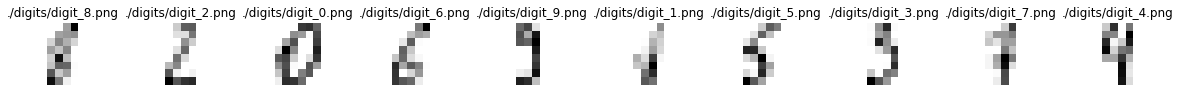

In [11]:
testImages = list(zip(map(preprocessImage, f), f))
plt.figure(figsize=(20,2))
for index, (im, name) in enumerate(testImages):
    plt.subplot(1, len(testImages), index + 1)
    plt.axis('off')
    plt.imshow(im.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%s' % name)
plt.subplots_adjust(wspace=0.9)

In [12]:
from sklearn.preprocessing import minmax_scale
#train on all available data
#scale dataset in the same way as our own sample
scaledX = minmax_scale(X)
finalModel = LGBMClassifier()
finalModel.fit(scaledX, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [13]:
import re
#predict
testDigitsPred = finalModel.predict(list(zip(*testImages))[0])
print('predicted:\t', testDigitsPred)
testDigitsLabels = np.array(list(map(lambda fn: int(re.sub(r'.*([0-9]).*', r'\1', fn)), list(zip(*testImages))[1])))
print('real:\t\t', testDigitsLabels)
print(metrics.classification_report(testDigitsLabels, testDigitsPred))

predicted:	 [7 2 0 5 3 7 5 1 7 9]
real:		 [8 2 0 6 9 1 5 3 7 4]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       0.00      0.00      0.00         1
          2       1.00      1.00      1.00         1
          3       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         1
          5       0.50      1.00      0.67         1
          6       0.00      0.00      0.00         1
          7       0.33      1.00      0.50         1
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         1

avg / total       0.28      0.40      0.32        10



/home/artem/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/artem/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Spam classification

In [14]:
#load data
import pandas as pd
data = pd.read_csv('./spam.csv', encoding='latin1')
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


[tf–idf wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

[Scikit docs](http://scikit-learn.org/stable/modules/feature_extraction.html#applications-and-examples)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

#encode categories
y = data['v1'].replace(['ham','spam'],[0,1]).values
#vectorize text using tf-idf
X_text = data['v2'].values
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')
X = vectorizer.fit_transform(X_text).toarray()
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#build model
spamModel = LGBMClassifier()
spamModel.fit(X_train, y_train)
#validation score
spamPred = spamModel.predict(X_test)
accuracy_score(y_test, spamPred)

/home/artem/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9770279971284996

In [16]:
#use model
spamText = 'URGENT! We are trying to contact U.Todays draw shows that you have won a 2000 prize GUARANTEED. Call 090 5809 4507 from land line. Claim 3030. Valid 12hrs only'
goodText = 'Good evening, our hotel haven\'t got bar. There is a restaurant next door, which belongs to us. You can either attend for dinner in there or order room service from menu of restaurant. Kind regards'
#vectorize our samples !!!using the same vectorizer!!!
testVector = vectorizer.transform([spamText, goodText]).toarray()
#get results
spamModel.predict(testVector)

/home/artem/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([1, 0])

# Clustering

Examples:

http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

https://dzone.com/articles/cluster-image-with-k-means